In [1]:
!pip install deepface ultralytics faiss-cpu pandas

In [17]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random

import numpy as np
import faiss

In [18]:
model_name = "Facenet" 
detector_backend = "opencv"
num_dimensions = 128 # Facenet output

In [19]:
representations = []

# Inisialisasi DataFrame Pandas untuk menyimpan nama orang dan embedding
df = pd.DataFrame(columns=["name", "embedding", "posisi"])

# Dictionary untuk mapping file_name ke nama orang
file_to_name = {
    "img5.jpg" : "Angelina Jolie",
    "img6.jpg" : "Angelina Jolie",
    "img14.jpg" : "Mark Zuckerberg",
    "img15.jpg" : "Mark Zuckerberg",
    "img17.jpg" : "Jack Dorsey",
    "img54.jpg" : "Jennifer Aniston",
    "img56.jpg" : "Jennifer Aniston",
    "img62.jpg" : "Jack Dorsey"
}
name_to_position = {
    "Angelina Jolie" : "Oscar Actress",
    "Mark Zuckerberg" : "CEO Meta",
    "Jack Dorsey" : "CEO Square",
    "Jennifer Aniston" : "Friends serial actress"
}
for r, d, files in os.walk("../Belajar-DeepFace"):
    for file in files:
        if ".jpg" in file:
            exact_file = f"{r}/{file}"
            objs = DeepFace.represent(
                img_path=exact_file,
                model_name=model_name,
                detector_backend=detector_backend
            )
            
            # Dapatkan nama orang dari dictionary
            name = file_to_name.get(file, "Unknown")  # Jika file tidak ada dalam dictionary, beri nama 'Unknown'
            posisi = name_to_position.get(name, "unknown position")
            for obj in objs:
                embedding = obj["embedding"]
                representations.append([file, embedding])
                
                # Buat DataFrame baru dari nama dan embedding yang dihasilkan
                new_row = pd.DataFrame({"name": [name], "embedding": [embedding], "posisi": [posisi]})
                
                # Gabungkan DataFrame baru ke DataFrame utama menggunakan pd.concat()
                df = pd.concat([df, new_row], ignore_index=True)

In [20]:
# number of dimension
for obj in objs:
    print(len(obj["embedding"]))

128


In [21]:
print(df)

               name                                          embedding  \
0   Mark Zuckerberg  [-1.1351802349090576, -0.869420051574707, -1.9...   
1   Mark Zuckerberg  [-1.101804494857788, -0.8272171020507812, -1.6...   
2       Jack Dorsey  [-0.9749082326889038, -0.7117679119110107, -1....   
3    Angelina Jolie  [-0.9477616548538208, 0.3950599431991577, 1.10...   
4  Jennifer Aniston  [-1.136723518371582, 0.8382779359817505, -0.73...   
5  Jennifer Aniston  [-0.2428605556488037, 1.4513887166976929, -0.2...   
6    Angelina Jolie  [-0.1228729635477066, 1.0534138679504395, 1.58...   
7       Jack Dorsey  [-0.9425913095474243, -1.3567501306533813, -0....   

                   posisi  
0                CEO Meta  
1                CEO Meta  
2              CEO Square  
3           Oscar Actress  
4  Friends serial actress  
5  Friends serial actress  
6           Oscar Actress  
7              CEO Square  


In [22]:
# Konversi embedding ke numpy array untuk FAISS
embeddings = df['embedding'].tolist()  # Ambil embedding dari DataFrame
embeddings = np.array(embeddings, dtype="f")  # Konversi ke numpy array

In [23]:
# Inisialisasi FAISS
index = faiss.IndexFlatL2(num_dimensions)

In [24]:
# Tambahkan embedding ke FAISS
index.add(embeddings)

In [25]:
# Simpan DataFrame ke CSV jika diperlukan
df.to_csv("face_embeddings.csv", index=False)

In [26]:
print(f"deepface unit test items have {len(representations)} images")

deepface unit test items have 8 images


In [27]:
embeddings = []
for key, value in representations:
    embeddings.append(value)

In [28]:
# euclidean
tic = time.time()
index = faiss.IndexFlatL2(num_dimensions)
toc = time.time()
print(f"faiss instance is initialized in {toc-tic} seconds")

faiss instance is initialized in 0.0009999275207519531 seconds


In [29]:
tic = time.time()
index.add(np.array(embeddings, dtype = "f"))
toc = time.time()
print(f"{len(embeddings)} vectors stored in faiss intance in {toc-tic} seconds")

8 vectors stored in faiss intance in 0.0 seconds


1th closest match: Mark Zuckerberg


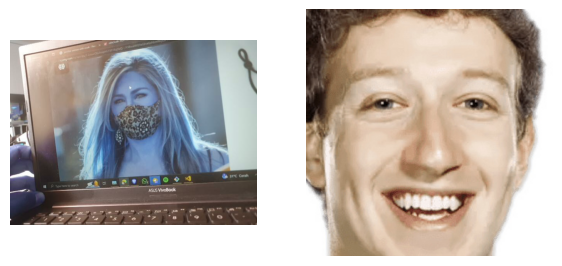

Hallo Mark Zuckerberg CEO Meta, selamat datang


In [37]:
# --- Tambahkan Webcam Input ---

# Inisialisasi webcam
cap = cv2.VideoCapture(1)

img_counter = 0
while True:
    # Baca frame dari webcam
    ret, frame = cap.read()

    # Tampilkan frame dari webcam
    cv2.imshow('Webcam', frame)

    # Tunggu input dari user, jika tekan 's', ambil gambar
    key = cv2.waitKey(1)
    if key%256 == 27:
        # ESC pressed untuk keluar
        print("Escape hit, closing...")
        break
        # Simpan frame yang di-capture sebagai target
    elif key%256 == 32:
        # SPACE pressed untuk capture
        target_img = "opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(target_img, frame)
        target_img = frame
        break

# Lepaskan resource webcam dan tutup window
cap.release()
cv2.destroyAllWindows()

# Proses gambar target dari webcam
target_embedding = DeepFace.represent(
    img_path=target_img,  # Menggunakan frame langsung
    model_name=model_name,
    detector_backend=detector_backend,
    enforce_detection=False  # Allow processing even if no face detected
)[0]["embedding"]

target_embedding = np.array(target_embedding, dtype="f")
target_embedding = np.expand_dims(target_embedding, axis=0)

# Cari embedding terdekat di FAISS
k = 1  # Jumlah neighbor terdekat yang ingin dicari
distances, neighbours = index.search(target_embedding, k)

# Tampilkan hasil pencarian dari DataFrame
for idx, neighbour in enumerate(neighbours[0]):
    if neighbour < len(df):
        neighbour_position = df.iloc[neighbour]['posisi']
        neighbour_name = df.iloc[neighbour]['name']
        neighbour_img_path = f"../Belajar-DeepFace/{representations[neighbour][0]}"
        
        # Ambil wajah neighbor dari gambar
        neighbour_img = DeepFace.extract_faces(
            img_path=neighbour_img_path,
            detector_backend=detector_backend
        )[0]["face"]
        
        # Visualisasikan gambar target dan neighbor
        print(f"{idx+1}th closest match: {neighbour_name}")
        
        fig = plt.figure(figsize=(7, 7))
        fig.add_subplot(1, 2, 1)    
        plt.imshow(target_img)
        plt.axis("off")
        fig.add_subplot(1, 2, 2)
        plt.imshow(neighbour_img)
        plt.axis("off")
        plt.show()
    else:
        print(f"Index {neighbour} out of range for DataFrame")

print(f"Hallo {neighbour_name} {neighbour_position}, selamat datang")